In [59]:
# imports
import anndata
import numpy
%matplotlib inline
import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore

# Gaussian mixture model
from sklearn.mixture import BayesianGaussianMixture

import random
random.seed(0)

In [8]:
# function taken from: https://www.cbrinton.net/ECE20875-2020-Spring/W11/gmms_notebook.pdf
 # Plot function
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute PDF of whole mixture
    x = np.linspace(-6, 6, 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    # Plot data histogram
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label
    ='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')

    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    ax.set_ylim(0,4)
    ax.set_xlim(-2,2)
    if show_legend:
        ax.legend()

### Test on Drosophila example

In [2]:
sdge = np.genfromtxt("droso_sdge.csv", delimiter=",")

In [3]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
atlas_dir = '../../novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values
locations = locations_apriori

atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

/tmp/ipykernel_36906/3621230534.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


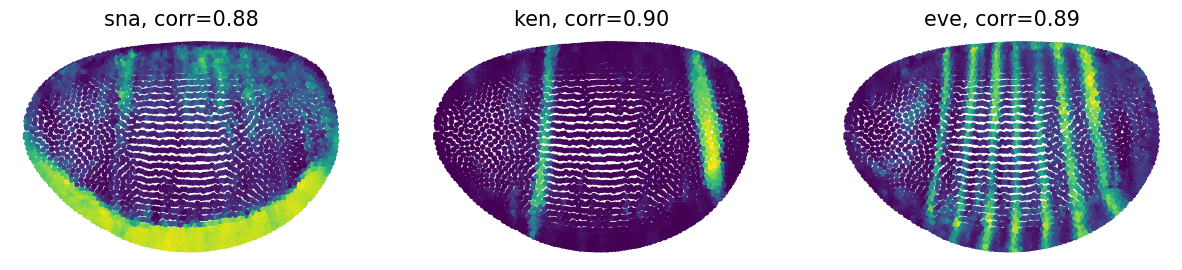

<Figure size 432x288 with 0 Axes>

In [4]:
# test original reconstructed expression of individual genes
pl_genes = ['sna', 'ken', 'eve']
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes, title=title)

## Make a minimal Test set with the three important genes

In [ ]:
sdge_test_cols = []
for i, gene in enumerate(pl_genes):
    if gene in dataset_reconst.var_names:
        sdge_test_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1,1))
sdge_test = np.concatenate(sdge_test_cols, axis=1)


### Different normalizing strategies

# normalize using zscore
sdge_test_normed_zscore = zscore(sdge_test)

# log transform
sdge_test_normed_log = np.log(sdge_test)


# min-max
sdge_test_normed_minmax = (sdge_test - np.min(sdge_test))/ (np.max(sdge_test) - np.min(sdge_test))


In [9]:

#### single gene

# sdge = 8924 (genes) x 3039 (locations)
# concatenate two different genes to get a test for having multiple distributions on 1 gene
# sdge_small = np.concatenate((sdge.T[:,1789], sdge.T[:,3])) # this results in two distributions of # equal size

# only gene sna
sdge_small = sdge_test_normed_zscore[:,0].reshape(-1,1)

# other test versions
# sdge_small = np.concatenate((sdge.T[:,1789], sdge.T[:,3], sdge.T[:,90])) # I wanted to have one dist more locations than the other - but doing it like this results in only having one label again?
# sdge_small = sdge.T[:,367] # it can happen that there is only 1 distribution but the label is 1 not 0?

sdge_small

array([[-0.38857064],
       [ 0.0219252 ],
       [-0.319131  ],
       ...,
       [ 1.6606932 ],
       [ 1.9166899 ],
       [-0.6467365 ]], dtype=float32)

# Bayesian GMM

## single test and plotting

In [34]:
# apply model
gmm = BayesianGaussianMixture(n_components=2, verbose=1).fit(sdge_small.reshape(-1,1))

# # get label for distributions
labels = gmm.predict(sdge_small.reshape(-1,1))
print(0 in labels)
print(1 in labels)
# count locations per distribution
print(pd.Series(labels).value_counts())

gmm1 = BayesianGaussianMixture(n_components=2, verbose=1,
                               covariance_prior= [(10,)]).fit(sdge_small.reshape(-1,1))
# # get label for distributions
labels1 = gmm1.predict(sdge_small.reshape(-1,1))
print(0 in labels1)
print(1 in labels1)
# count locations per distribution
print(pd.Series(labels1).value_counts())

gmm2 = BayesianGaussianMixture(n_components=2, verbose=1,
                              covariance_prior=[(100,)],
                               ).fit(sdge_small.reshape(-1,1))

# # get label for distributions
labels2 = gmm2.predict(sdge_small.reshape(-1,1))
print(0 in labels2)
print(1 in labels2)
# count locations per distribution
print(pd.Series(labels2).value_counts())

print(gmm.means_)
print(gmm1.means_)
print(gmm2.means_)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
True
True
0    2384
1     655
dtype: int64
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
True
True
0    2354
1     685
dtype: int64
Initialization 0
  Iteration 10
Initialization converged: True
True
True
0    2242
1     797
dtype: int64
[[-0.4722906 ]
 [ 1.72407231]]
[[-0.49317601]
 [ 1.68479348]]
[[-0.55095434]
 [ 1.51471154]]


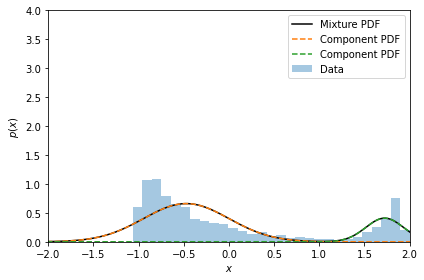

In [35]:
plot_mixture(gmm, sdge_small)
plt.tight_layout()

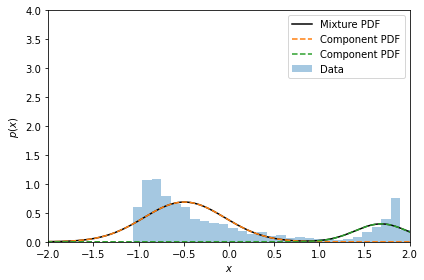

In [36]:
plot_mixture(gmm1, sdge_small)
plt.tight_layout()

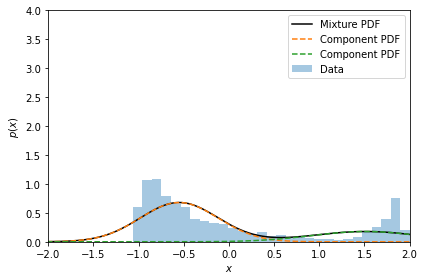

In [37]:
plot_mixture(gmm2, sdge_small)
plt.tight_layout()

## test on genes

In [56]:
# using zscore normalized

sdge_modded_cols = []

for column in sdge_test_normed_zscore.T:
    # apply model
    gmm = BayesianGaussianMixture(n_components=2, verbose=1,
                              covariance_prior=[(300,)],
                               ).fit(column.reshape(-1,1))
    # get labels< for distributions
    labels = gmm.predict(column.reshape(-1,1))

    # merge labels column with original expression value column
    label_assignment = np.concatenate((column.reshape(-1,1),
                                   labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_zscore = np.concatenate(sdge_modded_cols, axis=1)

Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True


# test it

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_36906/319656001.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(sdge_modded_zscore, columns=pl_genes))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


original


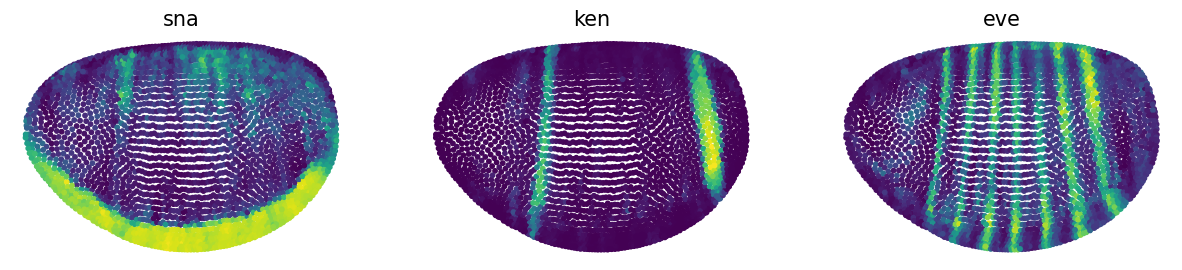

zscore


<Figure size 432x288 with 0 Axes>

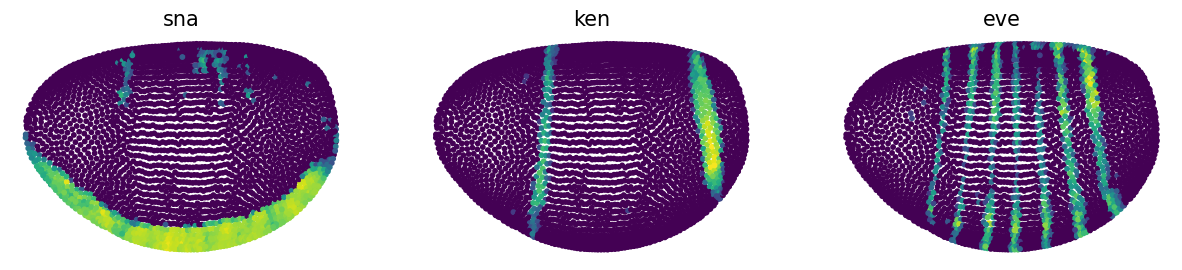

<Figure size 432x288 with 0 Axes>

In [57]:
one_gene = ['sna']
dataset_test = sc.AnnData(pd.DataFrame(sdge_test, columns=pl_genes))
# test cleaned reconstructed expression of individual genes
# dataset_cleaned_minmax = sc.AnnData(pd.DataFrame(sdge_modded_minmax, columns=pl_genes))
# dataset_cleaned_log = sc.AnnData(pd.DataFrame(sdge_modded_log, columns=pl_genes))
dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(sdge_modded_zscore, columns=pl_genes))

# dataset_small = sc.AnnData(pd.DataFrame(sdge_small, columns=one_gene))
# dataset_cleaned_minmax.obsm['spatial'] = locations
# dataset_cleaned_log.obsm['spatial'] = locations
dataset_cleaned_zscore.obsm['spatial'] = locations
dataset_test.obsm['spatial'] = locations
#dataset_small.obsm['spatial'] = locations

# plot
print("original")
novosparc.pl.embedding(dataset_test, pl_genes)
# print("normalized minmax")
# novosparc.pl.embedding(dataset_cleaned_minmax, pl_genes)
# print("normalized log transformed")
# novosparc.pl.embedding(dataset_cleaned_log, pl_genes)
print("zscore")
novosparc.pl.embedding(dataset_cleaned_zscore, pl_genes)

In [58]:
len(pl_genes)

3

# Test on full matrix

In [ ]:
%%time
# using zscore normalized
# normalize using zscore
sdge_normed_zscore = zscore(sdge)


sdge_modded_cols = []

for column in sdge_normed_zscore.T:
    # apply model
    gmm = BayesianGaussianMixture(n_components=2,
                                 covariance_prior=[(200,)],
                               ).fit(column.reshape(-1,1))
    # get labels< for distributions
    labels = gmm.predict(column.reshape(-1,1))

    # merge labels column with original expression value column
    label_assignment = np.concatenate((column.reshape(-1,1),
                                   labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_zscore = np.concatenate(sdge_modded_cols, axis=1)